# Projekt 1: Inferencia a Trest Smrti

Vitajte vo vašom prvom projekte! Dnes spolu zistíme či existuje medzi trestom smrti a počtom vrážd nejaký vzťah.  

### Úvod

**Spolupráca.** Môžete pracovať samostatne alebo v pároch.

**Pravidlá.** Nezdieľajte kód s ostatnými účastníkmi. Pomáhať im verbálne však môžete.

**Pomoc.** Nie ste v tom sami! Pýtajte sa, občas sa len takto dá pohnúť ďalej.

**Rada od nás.** Vyvíjajte riešenia inkrementálne. Komplikovaná tabuľková operácia sa dá rozdeliť na čiastočné. Pridajte si akékoľvek mená či funkcie, ktoré sa vám hodia. Neobmedzujte sa v používaní knižníc, pokiaľ viete, ako ich používať.
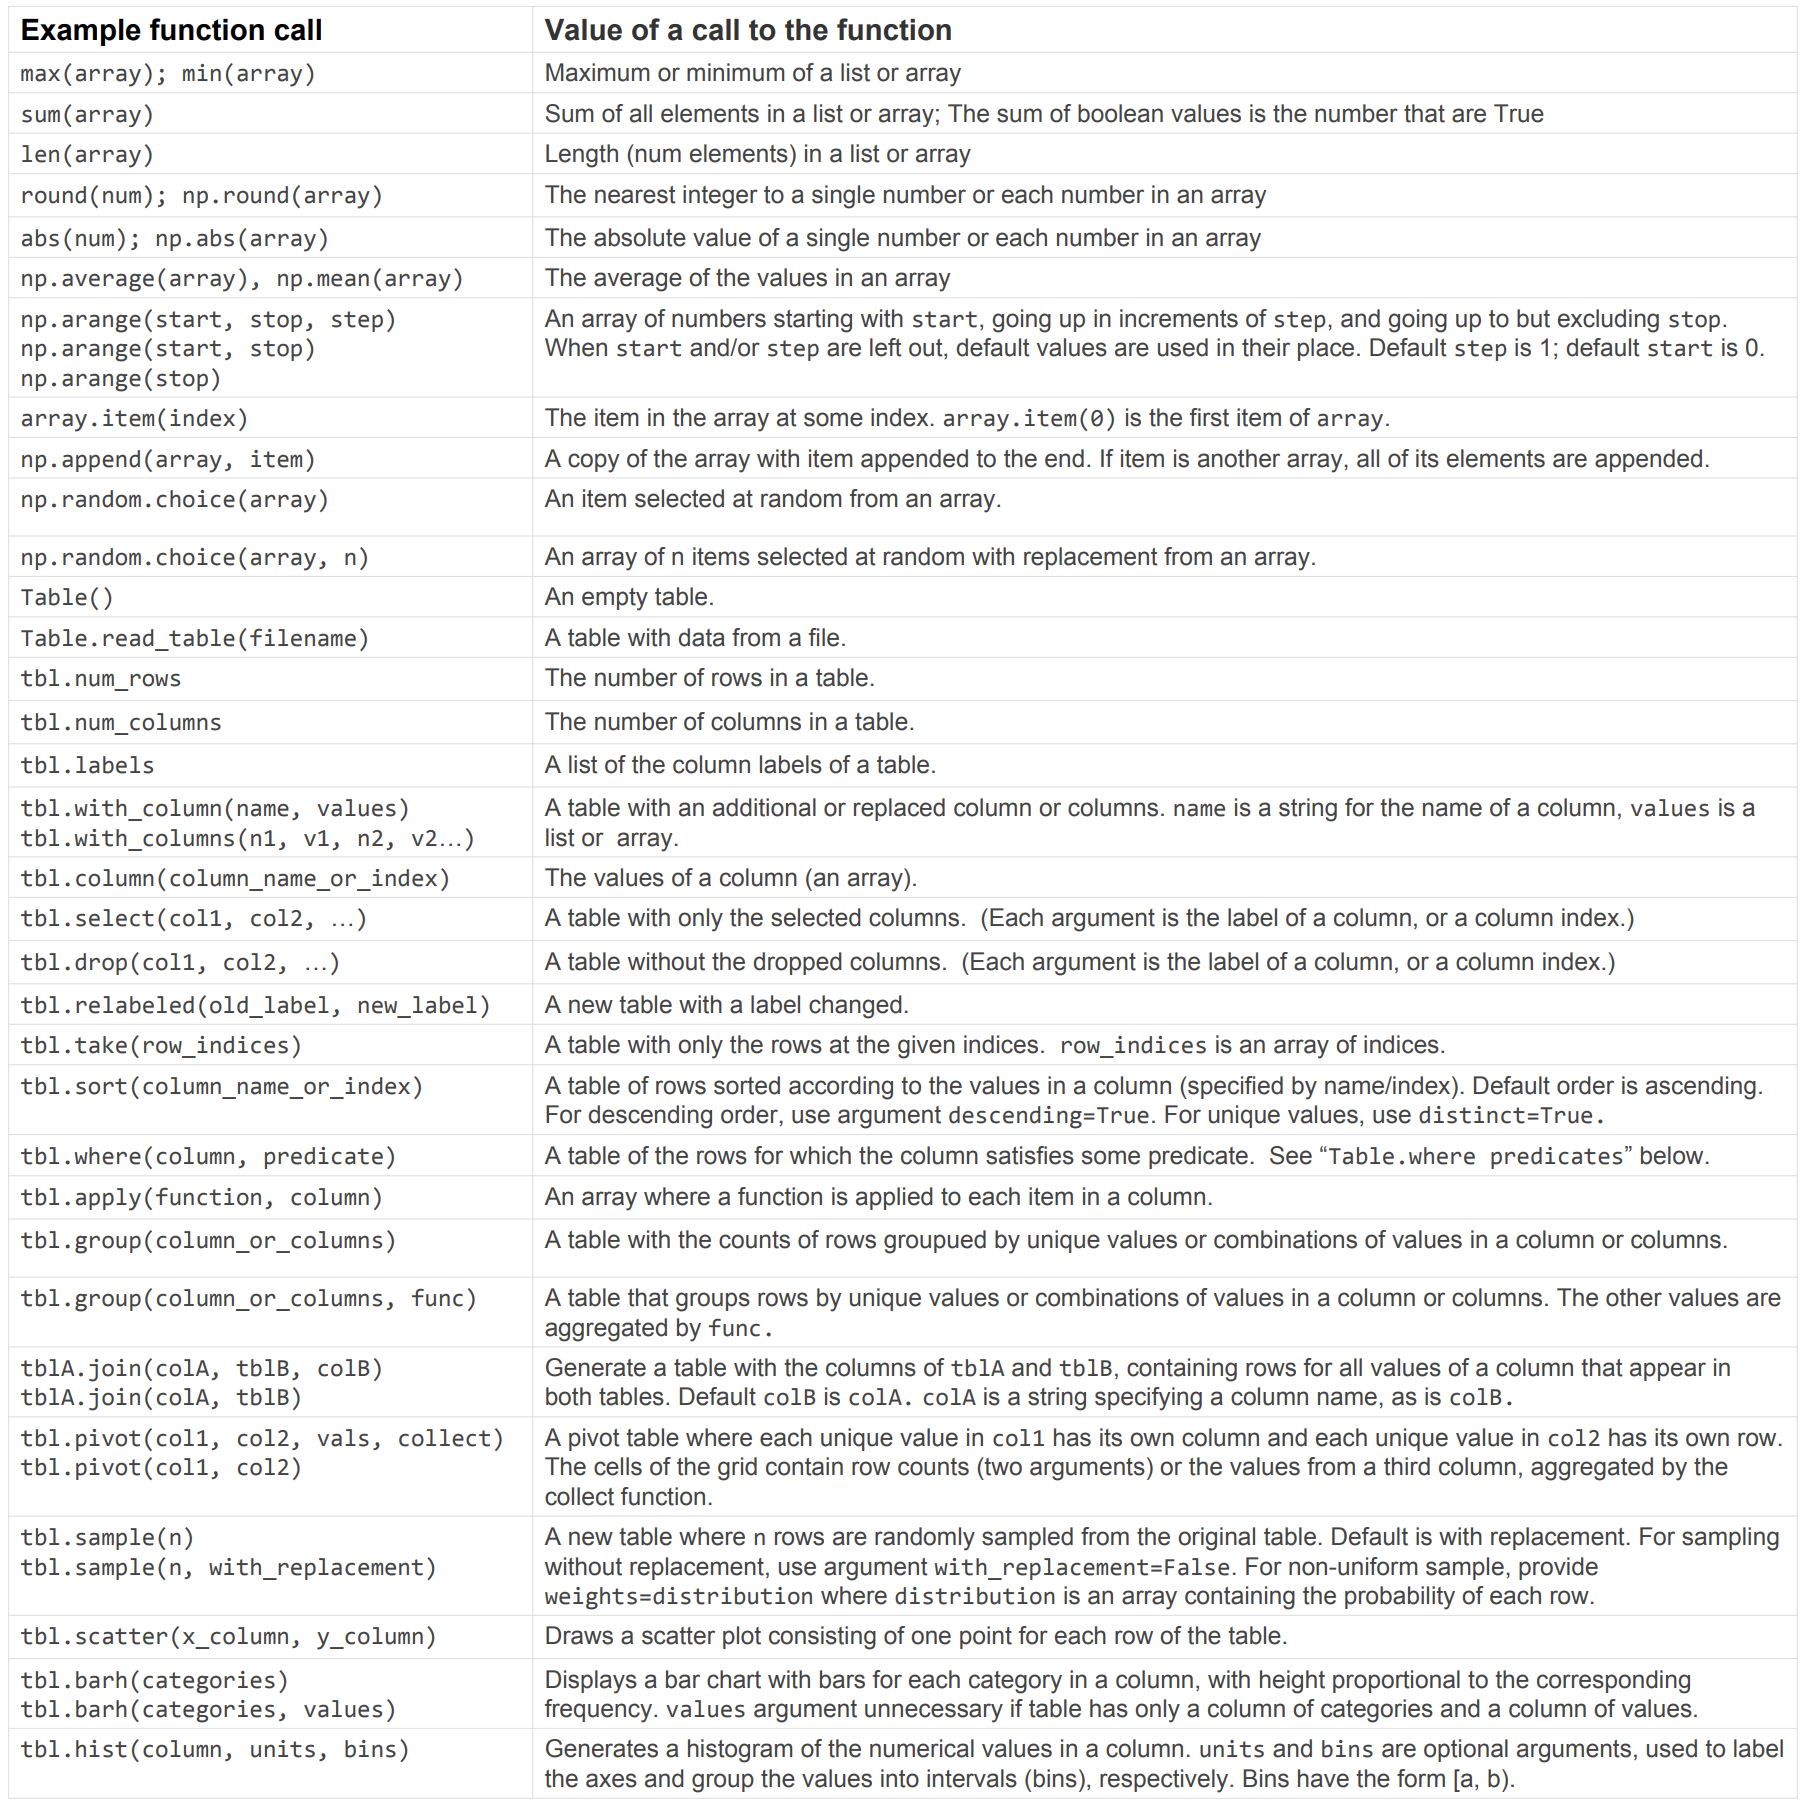

Na začiatok, importujme knižnice `datascience` (rôzne dáta), `numpy` (numerické operácie) a `plots` (plotovanie z matplotlibu).

In [ ]:
from datascience import *
import numpy as np

from tests import correct_extra_info

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Intro

Trest smrti je dodnes nevyriešeným etickým problémom. Napriek kontroverznosti, "zastrašovanie" bol v zásade jediný bod všetkých debát. Samozrejme existuje mnoho iných dôvodov, prečo (ne)podporovať trest smrti, v tomto projekte sa však zameriame len na efekt "zastrašenia".

Základnou otázkou je:

> Pomohlo zavedenie trestu smrti znížiť počet vrážd?

Napriek silnej intuícii z prvého dojmu, odpoveď na túto otázku je veľmi komplexná. Rôzne názorové vetvy argumentujú rozličnžmi štatistickými prístupmi. My si dnes skúsime vytvoriť vlastný názor na základe dát!


### Dáta

Všetky dáta v tomto projekte pochádzajú z tohto zdroja: [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) (práca troch výskumníkov). Dataset obsahuje rôzne trestné činy v období 1960-2003 pre každý štát USA. Dáta pôvodne pochádzajú z databáz FBI.

Keďže trestné činy páchajú ľudia a nie štáty, potrebujeme reprezentovať krajiny cez počet obyvateľov. Pomer vrážd (muder rate) potom vypočítame takto:

$$\text{murder rate pre štát X v roku Y} = \frac{\text{počet vrážd v štáte X v roku Y}}{\text{počet obyvateľov v štáte X v roku Y}}*100000$$

(Vražda je netypická udalosť, preto to násobíme faktorom 100,000)

In [ ]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

# 1. Murder rate - analýza

Doposiaľ nemáme v datasete jedinú asociačnú informáciu medzi vraždami a zavedením trestom smrti. 

**Otázka 1.** Aké informácie ešte potrebujeme predtým, než začneme analyzovať hľadanú asociáciu? Vytvorte Pythonovský list `extra_info`, v ktorom sa budú nacáhdzať indexy všetkých informácií, ktoré podľa vás potrebujeme.

1) V ktorom roku bol zavedený trest smrti pre jednotlivé krajiny (ak vôbec).

2) Denno-denné dáta, kedy presne nastali jedlotlivé vraždy.

3) V ktorom roku bol trest smrti zrušený (ak vôbec).

4) Výskyt iných trestných činov v daných krajinách.

In [ ]:
extra_info = ...
# otestuj si svoje riesenie:
correct_extra_info(extra_info)

Mureder rate sa pre danú krajinu mení v čase. Niektoré sú stabilné, iné sa menia dramaticky.

**Otázka 2.** Nakresli plot s rokmi na x-ovej osi a muder rates na y-ovej osi. Nech sú na jednom grafe dve krivky - pre Aljašku a Minessotu.

Plot vytvoríte veľmi jednoducho, stačí zavolať: `ak_mn.plot('Year')`

*Hint*: Správne riešenie si vyžaduje vytvoriť tabuľku nasledujúceho charakteru:


| Year | Murder rate in Alaska | Murder rate in Minnesota |
|------|-----------------------|--------------------------|
| 1960 | 10.2                  | 1.2                      |
| 1961 | 11.5                  | 1                        |
| 1962 | 4.5                   | 0.9                      |

<center>... (41 rows omitted)</center>

In [ ]:
# Nasledujúce riadky sme predpripravili pre vás. 
# Vytvárajú tabuľky s relevantnými informáciami pre Aljašku a Minnesotu.
Alaska = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
Minnesota = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')

# Doplň chýbajúci riadok, aby vznikol taký graf, aký vidíte nižšie
alaska_minnesota = ...
alaska_minnesota.plot('Year')

Teraz z toho spravíme funkciu pre ľubovolné dve krajiny. Dokonca interaktívne. Vyskúšajte si a porovnajte ľubovoľné dve krajiny! Všimli ste si niečo?

In [ ]:
# Compare the murder rates of any two states by filling in the blanks below
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def state(state1, state2):
    state1_table = murder_rates.where('State', state1).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state1))
    state2_table = murder_rates.where('State', state2).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state2))
    s1_s2 = state1_table.join('Year', state2_table)
    s1_s2.plot('Year')
    plots.show()

states_array = murder_rates.group('State').column('State')

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
            )

# 2. Trest smrti - analýza

Niektoré štáty USA zaviedli trest smrti a niektoré nie. Skúsme sa pozrieť na to, ako sa murder rate zmenil v od dátumu zavedenia trestu smrti.

**Otázka 3.** Popíš, ako by mal vyzerať experiment. Akú populáciu študujeme? Kot je Target a kto je Kontrolná skupina? Aký výstup vlastne očakávame? Skúste byť konkrétni.

*Napíšte sem svoje odpovede:*

- Populácia:
- Target skupina:
- Kontrolná skupina:
- Výstup:

## Experiment


V tomto experimente využijeme informáciu, že tresty smrti boli naprieč väčšinou krajín USA zrušené. Stalo sa to v roku 1972, takže celý experiment si nadefinujeme zhruba takto:

> **Populácia:** Všetky štáty, ktoré mali zavedený trest smrti pred rokom 1972. Musíme teda vynechať štáty: Alaska, Hawaii, Maine, Michigan, Wisconsin a Minnesota.

> **Target skupina:** Štáty po roku 1972

> **Kontrolná skupina:** Štáty pred rokom 1972

> **Null hypothesis:** 
Pravdepodobnosť, že murder rate sa po zrušení zákazu zvýšil je rovnaká, ako že sa znížil. (coin flip)

> **Alternatívna hypotéza:** Murder rate sa zvýšil. 

In [ ]:
# The `death_penalty` table below describes whether each state allowed the death penalty in 1971.
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

In [ ]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

In [ ]:
death_penalty_murder_rates = death_penalty.where(1, 1).join('State', 
                                murder_rates).drop(1)
death_penalty_murder_rates

Testovná štatistika:

In [ ]:
difference = (death_penalty_murder_rates.where('Year', 1973).column('Murder Rate'
                    ) - death_penalty_murder_rates.where('Year', 1971).column('Murder Rate'))
test_stat_72 = sum(difference > 0) - sum(difference < 0)
print('Test statistic from 1971 to 1973:', test_stat_72)

Pozrime sa na náhodné dáta, aby sme si 

Histogram s nulovou hypotézou:

In [ ]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of our
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
    sample = uniform.sample_from_distribution('Chance', num_chances_to_change).column('Chance sample')
    return sample[0]-sample[1]

In [ ]:
samples = make_array()
for i in np.arange(10000):
    samples = np.append(samples, simulate_under_null(44))
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 30, 2))
plots.scatter(test_stat_72, 0, color='red', s=200)

### Záver
Odpovedz na otázky:
1. Ako vypočítať p-value?


2. Aký záver platí pre null hypothesis a alternative hypothesis?


3. Pokús sa v ľudskom jazyku vysvetliť zistenia z tvojej analáýzy. 


**P-value:** ...

**Hypotézy:** ...

**Zistenia:** ...

In [ ]:
average_murder_rates.plot('Year')

Pozrime sa na Kanadu:

In [ ]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

Oficiálny výskum: [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

<img src="paper_plot.png"/>


Kanada neodsúdila nikho na smerť od roku 1962. Zaujímavé je, že miera vrážd v Kanade stúpla úplne rovnako ako v USA.

**Hotovo!**